# **OPLS-DA pipeline**


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import cross_validation
import plotting
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import permutation_test_score
from sklearn.cross_decomposition import PLSRegression

import warnings
warnings.filterwarnings('ignore')

from pyChemometrics import ChemometricsScaler



In [2]:
df_path = '/Users/aeiwz/Library/CloudStorage/OneDrive-KhonKaenUniversity/KKUPC/Project/Alpha/KKUPC6602013/Re-analyse/Raw data/Dataset'

df = pd.read_csv('{}/KKUPC6602013_dataset.csv'.format(df_path))

In [3]:
#Drop row are contain QC in Group column
df = df[df['Group'] != 'QC']

In [4]:
test_select = pd.concat([df.loc[df['Intervention'] == df['Intervention'].unique()[0]], df.loc[df['Intervention'] == df['Intervention'].unique()[1]]], axis=0)

In [5]:
spectra = test_select.iloc[:, 28:]
ppm = list(spectra.columns.astype(float))
X = spectra.values
y = test_select['Intervention'].values

In [6]:
# Create a pipeline with data preprocessing and OPLS-DA model
pipeline = Pipeline([
    ('scale', ChemometricsScaler(scale_power=0.5)),
    ('oplsda', PLSRegression(n_components=2)),
    ('opls', cross_validation.CrossValidation(kfold=3, estimator='opls', scaler='pareto'))
])

In [7]:
oplsda = pipeline.named_steps['oplsda']

In [8]:
oplsda.fit(X, pd.Categorical(y).codes)

PLSRegression()

In [9]:
cv = pipeline.named_steps['opls']

In [10]:
cv.fit(X, y)

In [11]:
n_permutate = 1000

# Permutation test to assess the significance of the model
acc_score, permutation_scores, p_value = permutation_test_score(
    pipeline.named_steps['oplsda'], X, pd.Categorical(y).codes, cv=2, n_permutations=n_permutate, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1868470850699848s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07653212547302246s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12043881416320801s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16694188117980957s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 160 tasks      |

In [12]:
print('Accuracy score: {0}, p-value: {1}'.format(acc_score, p_value))

Accuracy score: 0.0, p-value: 0.06693306693306693


In [13]:
p_value, acc_score

(0.06693306693306693, 0.0)

In [14]:
plot = plotting.Plots(cv)

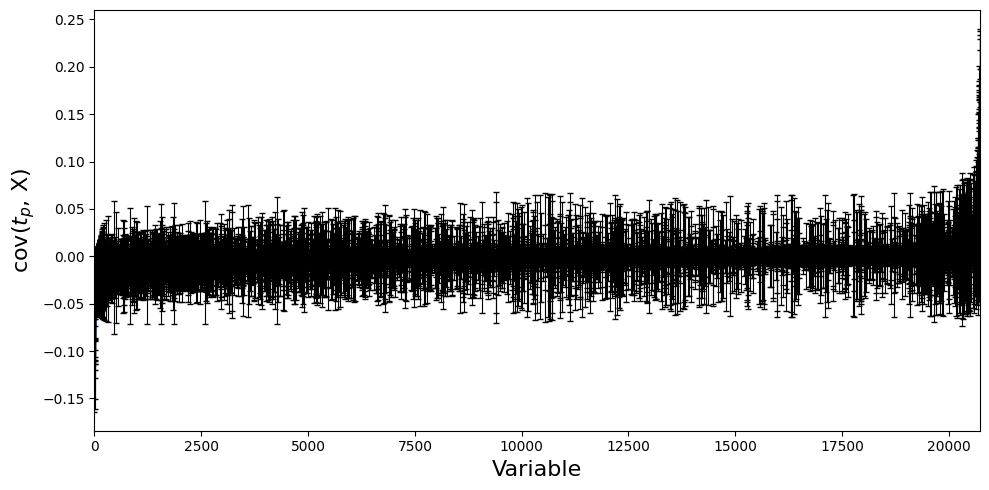

(array([ 2.26695553e-04, -5.95609825e-04, -1.23851311e-03, ...,
         1.17701666e-03,  3.40157707e-04, -6.32082996e-05]),
 array([0.00300707, 0.00411035, 0.00309178, ..., 0.0027107 , 0.00269157,
        0.00178188]))

In [15]:
plot.jackknife_loading_plot()

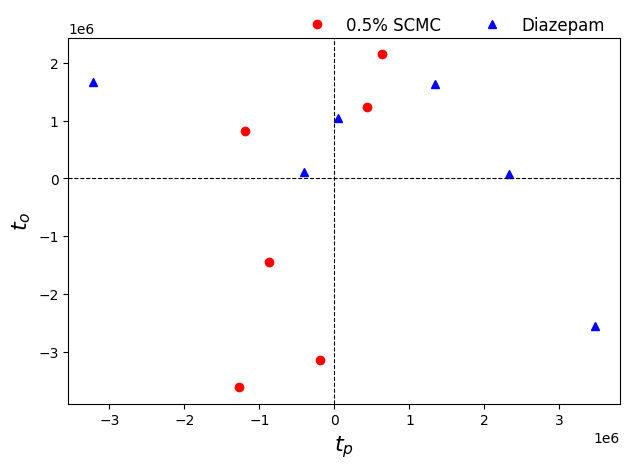

In [16]:
plot.plot_scores()

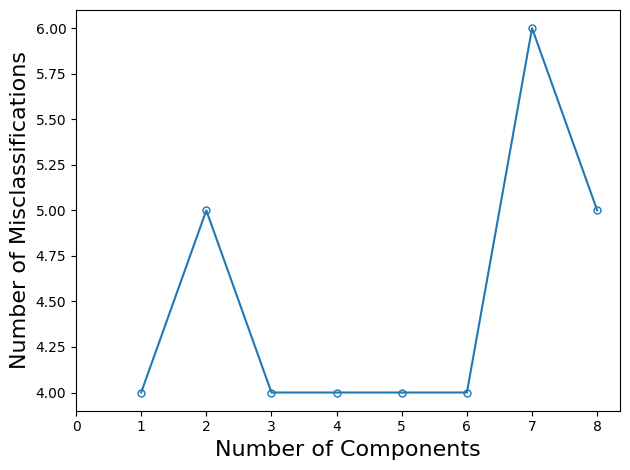

In [17]:
plot.plot_cv_errors()

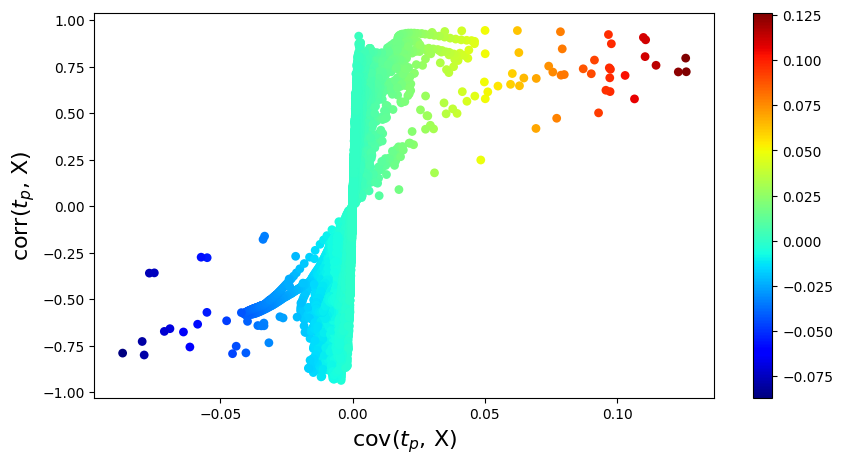

In [18]:
plot.splot()

In [19]:
s_scores_df = pd.DataFrame({'correlation': cv.correlation,'covariance': cv.covariance}, index=ppm)

In [33]:
# sub-plot covariance for x and correlation for y S-plot using plotly, color by covariance with jet colormap
#setup figure size


fig = px.scatter(s_scores_df, x='covariance', y='correlation', color='covariance', color_continuous_scale='jet', text=s_scores_df.index, height=900, width=2000)
fig.update_layout(title='<b>S-plot</b>', xaxis_title='Covariance', yaxis_title='Correlation')
fig.update_layout(title_x=0.5)
#Set background color to transparent

#add line of axis and set color to black and line width to 2 pixel
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
#Add tick width to 2 pixel
fig.update_xaxes(tickwidth=2)
fig.update_yaxes(tickwidth=2)
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)')
fig.update_yaxes(tickformat=",.0")
fig.update_xaxes(tickformat=",.0")
fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
fig.update_layout(
    title={
        'y':1,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(size=20))
#Set font size to 20
#Set marker size to 5 pixel
fig.update_traces(marker=dict(size=8))
fig.show()

fig = px.scatter(s_scores_df, x=ppm, y=np.median(X, axis=0), color='covariance', color_continuous_scale='jet', text=s_scores_df.index, height=500, width=2000)

fig.update_traces(marker=dict(size=3))
fig.update_xaxes(autorange="reversed")
fig.update_layout(title='<b>Median spectra</b>', xaxis_title='ppm', yaxis_title='Intensity (AU)')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
#Add tick width to 2 pixel
fig.update_xaxes(tickwidth=2)
fig.update_yaxes(tickwidth=2)

fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)')
fig.update_yaxes(tickformat=",.0")
fig.update_xaxes(tickformat=",.0")
fig.update_layout(
    title={
        'y':1,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(size=20))
#Set marker size to 5 pixel
fig.update_traces(marker=dict(size=3))
fig.show()




In [23]:
df_opls_scores = pd.DataFrame({'t_ortho': cv.orthogonal_score, 't_pred': cv.predictive_score, 'label': y})

In [76]:
from pca_ellipse import confidence_ellipse
fig = px.scatter(df_opls_scores, x='t_pred', y='t_ortho', 
                 color='label', 
                 color_discrete_map={
                                    "UCMS": "#E91E63",        
                                    "TKM powder 150 mg/kg": "#FF9800",
                                    "Imipramine": "#FFEB3B",       
                                    "TKM powder 37.5 mg/kg": "#9C27B0",
                                    "Vitamin E": "#03A9F4",
                                    "Diazepam": "#4CAF50",        
                                    "TKM powder 600 mg/kg": "#B30000",
                                    "0.5% SCMC": "#3F51B5",
                                    "No class of prediction": "#000000"
                                    }, 
                title='<b>OPLS-DA Scores Plot<b>', 
                height=900, width=1300,
                labels={
                    't_pred': 't<sub>predict</sub>',
                    't_ortho': 't<sub>orthogonal</sub>',
                    'label': 'Intervention'}
                )

#fig.add_annotation(yref = 'paper', y = -1.06, xref = 'paper', x=1.06 , text='Q2' +' = {}'.format(np.round(df_explained_variance_.iloc[2,2], decimals=2)))
#fig.update_annotations(font = {
#    'size': 20}, showarrow=False)

#set data point fill alpha with boarder in each color
fig.update_traces(marker=dict(size=35, opacity=0.7, line=dict(width=2, color='DarkSlateGrey')))

fig.add_annotation(dict(font=dict(color="black",size=20),
                        #x=x_loc,
                        x=0,
                        y=1.04+0.05,
                        showarrow=False,
                        text='<b>R<sup>2</sup>X: {}%<b>'.format(np.round(cv.R2X*100, decimals=2)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left")

fig.add_annotation(dict(font=dict(color="black",size=20),
                        #x=x_loc,
                        x=0,
                        y=1.0+0.05,
                        showarrow=False,
                        text='<b>R<sup>2</sup>Y: {}<b>'.format(np.round(cv.R2y*100, decimals=2)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left")
fig.add_annotation(dict(font=dict(color="black",size=20),
                        #x=x_loc,
                        x=0,
                        y=1.08+0.05,
                        showarrow=False,
                        text='<b>Q<sup>2</sup>: {}<b>'.format(np.round(cv.q2*100, decimals=2)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left")

fig.add_shape(type='path',
        path=confidence_ellipse(df_opls_scores['t_pred'], df_opls_scores['t_ortho']))


fig.update_traces(marker=dict(size=35))
#fig.update_traces(textposition='top center') #Text label position
#change M to 10^6
fig.update_yaxes(tickformat=",.0")
fig.update_xaxes(tickformat=",.0")

#fig.update_traces(marker=dict(size=12, color=Y1_color, marker=Y2_marker))

fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
fig.update_layout(
    title={
        'y':1,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(size=20))
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)')

fig.show()
#fig.write_image("{}/Scores_plot/PNG_scores/{}.png".format(path_, name[i]))
#fig.write_html("{}/Scores_plot/HTML_scores/{}.html".format(path_, name[i]))



In [ ]:
plot.plot_scores()

In [70]:
#Plot histogram of permutation scores
fig = px.histogram(permutation_scores, nbins=50, height=500, width=1000, 
                   title='<b>Permutation scores<b>',
                   labels={'value': 'Accuracy score', 
                           'count': 'Frequency'})
#add dashed line to indicate the accuracy score of the model
fig.add_shape(type='line', x0=acc_score, y0=0, x1=acc_score, y1=100, line=dict(dash='dash', color='red', width=3))
fig.add_annotation(dict(font=dict(color="black",size=20),
                        #x=x_loc,
                        x=0,
                        y=1.25,
                        showarrow=False,
                        text='<b>R<sup>2</sup>X: {}%<b>'.format(np.round(cv.R2X*100, decimals=3)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left",
                        font=dict(size=16))

fig.add_annotation(dict(font=dict(color="black",size=20),
                        #x=x_loc,
                        x=0,
                        y=1.18,
                        showarrow=False,
                        text='<b>R<sup>2</sup>Y: {}<b>'.format(np.round(cv.R2y*100, decimals=3)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="right",
                        font=dict(size=16))
fig.add_annotation(dict(font=dict(color="black",size=20),
                        #x=x_loc,
                        x=0,
                        y=1.11,
                        showarrow=False,
                        text='<b>Q<sup>2</sup>: {}<b>'.format(np.round(cv.q2*100, decimals=2)),
                        textangle=0,
                        xref="paper",
                        yref="paper"),
                        # set alignment of text to left side of entry
                        align="left",
                        font=dict(size=16))
                   
fig.update_layout(title_x=0.5)

fig.show()


